In [9]:
import pandas as pd
import matplotlib.pylab as plt
from PIL import Image, ImageDraw
import numpy as np
import os
%matplotlib inline

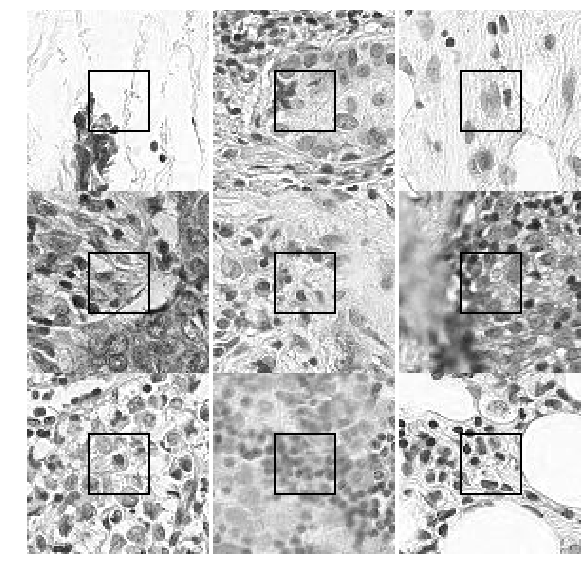

In [11]:
path2csv="./data/histopathologic-cancer-detection/train_labels.csv"
# get ids for malignant images
malignantIds = labels_df.loc[labels_df['label']==1]['id'].values

# data is stored here
path2train="./data/histopathologic-cancer-detection/train/"

# show images in grayscale, if you want color change it to True
color=False

plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
nrows,ncols=3,3

for i,id_ in enumerate(malignantIds[:nrows*ncols]):
    full_filenames = os.path.join(path2train , id_ +'.tif')
    # load image
    img = Image.open(full_filenames)
    # draw a 32*32 rectangle
    draw = ImageDraw.Draw(img)
    draw.rectangle(((32, 32), (64, 64)),outline="green")
    plt.subplot(nrows, ncols, i+1)
    if color is True:
        plt.imshow(np.array(img))
    else:
        plt.imshow(np.array(img)[:,:,0],cmap="gray")
        plt.axis('off')

In [12]:
print("image shape:", np.array(img).shape)
print("pixel values range from %s to %s" %(np.min(img),
np.max(img)))

image shape: (96, 96, 3)
pixel values range from 0 to 255


In [13]:
from PIL import Image
import torch
from torch.utils.data import Dataset
import pandas as pd
import torchvision.transforms as transforms
import os

# fix torch random seed
torch.manual_seed(0)


In [21]:
class histoCancerDataset(Dataset):
    def __init__(self, data_dir, transform,data_type="train"):
    # path to images
        path2data=os.path.join(data_dir,data_type)
        # get a list of images
        filenames = os.listdir(path2data)
        # get the full path to images
        self.full_filenames = [os.path.join(path2data, f) for f in
    filenames]
        # labels are in a csv file named train_labels.csv
        csv_filename=data_type+"_labels.csv"
        path2csvLabels=os.path.join(data_dir,csv_filename)
        labels_df=pd.read_csv(path2csvLabels)
        # set data frame index to id
        labels_df.set_index("id", inplace=True)
        # obtain labels from data frame
        self.labels = [labels_df.loc[filename[:-4]].values[0] for
        filename in filenames]
        self.transform = transform

    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)
    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx]) # PIL image
        image = self.transform(image)
        return image, self.labels[idx]

In [22]:
import torchvision.transforms as transforms
data_transformer = transforms.Compose([transforms.ToTensor()])

In [23]:
data_dir = "./data/histopathologic-cancer-detection/"
histo_dataset = histoCancerDataset(data_dir, data_transformer,
"train")
print(len(histo_dataset))

220025


In [24]:
img,label=histo_dataset[9]
print(img.shape,torch.min(img),torch.max(img))

torch.Size([3, 96, 96]) tensor(0.) tensor(1.)


In [25]:
from torch.utils.data import random_split

In [26]:
len_histo=len(histo_dataset)
len_train=int(0.8*len_histo)
len_val=len_histo-len_train
train_ds,val_ds=random_split(histo_dataset,[len_train,len_val])
print("train dataset length:", len(train_ds))
print("validation dataset length:", len(val_ds))

train dataset length: 176020
validation dataset length: 44005


In [28]:
for x,y in train_ds:
    print(x.shape,y)
    break

torch.Size([3, 96, 96]) 0


In [29]:
for x,y in val_ds:
    print(x.shape,y)
    break

torch.Size([3, 96, 96]) 1


In [30]:
from torchvision import utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)

In [31]:
def show(img,y,color=False):
    # convert tensor to numpy array
    npimg = img.numpy()
    # Convert to H*W*C shape
    npimg_tr=np.transpose(npimg, (1,2,0))
    if color==False:
        npimg_tr=npimg_tr[:,:,0]
        plt.imshow(npimg_tr,interpolation='nearest',cmap="gray")
    else:
        # display images
        plt.imshow(npimg_tr,interpolation='nearest')
        plt.title("label: "+str(y))

In [32]:
grid_size=4
rnd_inds=np.random.randint(0,len(train_ds),grid_size)
print("image indices:",rnd_inds)
x_grid_train=[train_ds[i][0] for i in rnd_inds]
y_grid_train=[train_ds[i][1] for i in rnd_inds]
x_grid_train=utils.make_grid(x_grid_train, nrow=4, padding=2)
print(x_grid_train.shape)

image indices: [ 43567 173685 117952 152315]
torch.Size([3, 100, 394])


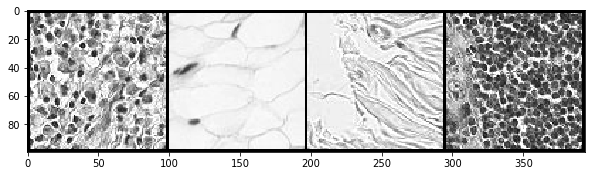

In [34]:
plt.rcParams['figure.figsize'] = (10.0, 5)
show(x_grid_train,y_grid_train)


image indices: [30403 32103 41993 20757]
torch.Size([3, 100, 394])


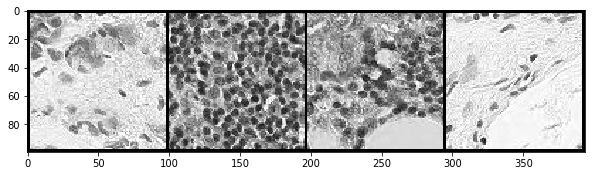

In [35]:
grid_size=4
rnd_inds=np.random.randint(0,len(val_ds),grid_size)
print("image indices:",rnd_inds)
x_grid_val=[val_ds[i][0] for i in range(grid_size)]
y_grid_val=[val_ds[i][1] for i in range(grid_size)]
x_grid_val=utils.make_grid(x_grid_val, nrow=4, padding=2)
print(x_grid_val.shape)
show(x_grid_val,y_grid_val)

In [38]:
train_transformer = transforms.Compose([
transforms.RandomHorizontalFlip(p=0.5),
transforms.RandomVerticalFlip(p=0.5),
transforms.RandomRotation(45),
transforms.RandomResizedCrop(96,scale=(0.8,1.0),ratio=(1.0,1.0)),
transforms.ToTensor()])

val_transformer = transforms.Compose([transforms.ToTensor()])

# overwrite the transform functions
train_ds.transform=train_transformer
val_ds.transform=val_transformer

In [39]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)

In [40]:
# extract a batch from training data
for x, y in train_dl:
    print(x.shape)
    print(y.shape)
    break


torch.Size([32, 3, 96, 96])
torch.Size([32])


In [41]:
# extract a batch from training data
for x, y in train_dl:
    print(x.shape)
    print(y.shape)
    break


torch.Size([32, 3, 96, 96])
torch.Size([32])


In [50]:
# get labels for validation dataset
y_val=[y for _,y in val_ds]

def accuracy(labels, out):
    return np.sum(out==labels)/float(len(labels))
# accuracy all zero predictions
acc_all_zeros=accuracy(y_val,np.zeros_like(y_val))
print("accuracy all zero prediction: %.2f" %acc_all_zeros)

# accuracy all ones predictions
acc_all_ones=accuracy(y_val,np.ones_like(y_val))
print("accuracy all one prediction: %.2f" %acc_all_ones)

# accuracy random predictions
acc_random=accuracy(y_val,np.random.randint(2,size=len(y_val)))
print("accuracy random prediction: %.2f" %acc_random)

accuracy all zero prediction: 0.59
accuracy all one prediction: 0.41
accuracy random prediction: 0.50


In [55]:
import torch.nn as nn
import numpy as np


In [56]:
def findConv2dOutShape(H_in,W_in,conv,pool=2):
    # get conv arguments
    kernel_size=conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation
    # Ref: https://pytorch.org/docs/stable/nn.html
    H_out=np.floor((H_in+2*padding[0]-
    dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    W_out=np.floor((W_in+2*padding[1]-
    dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)
    if pool:
        H_out/=pool
        W_out/=pool
    return int(H_out),int(W_out)

conv1 = nn.Conv2d(3, 8, kernel_size=3)
h,w=findConv2dOutShape(96,96,conv1)
print(h,w)

47 47


In [57]:
import torch.nn as nn
import torch.nn.functional as F

In [60]:
class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
        C_in,H_in,W_in=params["input_shape"]
        init_f=params["initial_filters"]
        num_fc1=params["num_fc1"]
        num_classes=params["num_classes"]
        self.dropout_rate=params["dropout_rate"]
        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3)
        h,w=findConv2dOutShape(H_in,W_in,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)
        # compute the flatten size
        self.num_flatten=h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, self.num_flatten)
        x = F.relu(self.fc1(x))
        x=F.dropout(x, self.dropout_rate, training= self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [64]:
# dict to define model parameters
params_model={
"input_shape": (3,96,96),
"initial_filters": 8,
"num_fc1": 100,
"dropout_rate": 0.25,
"num_classes": 2,
}
# create model
cnn_model = Net(params_model)
# move model to cuda/gpu device
if torch.cuda.is_available():
    device = torch.device("cuda")
    cnn_model=cnn_model.to(device)

print(cnn_model)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)


In [65]:
print(next(cnn_model.parameters()).device)

cpu


In [66]:
from torchsummary import summary
summary(cnn_model, input_size=(3, 96, 96),device=device.type)

ModuleNotFoundError: No module named 'torchsummary'